# Introduction


**What?** Quantile regression with application in pyTorch<br>



# Import modules

In [1]:
from statsmodels.regression.quantile_regression import QuantReg
import numpy as np
from sklearn.datasets import load_boston
from matplotlib import rcParams
import matplotlib.pyplot as plt
import copy
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import r2_score
from torch.nn import Module
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
from numpy import vstack, hstack
from numpy import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random

# Load the dataset


- Boston housing dataset
- The train/test split is here done manually



In [2]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1].astype('float32')
        self.y = df.values[:, -1].astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [3]:
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [4]:
# prepare the data
path = '../DATASETS/housingBoston_V2.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

339 167


In [5]:
train_dl

In [6]:
dataset = CSVDataset(path)
X=dataset.X
Y=dataset.y

In [7]:
X.shape

(506, 13)

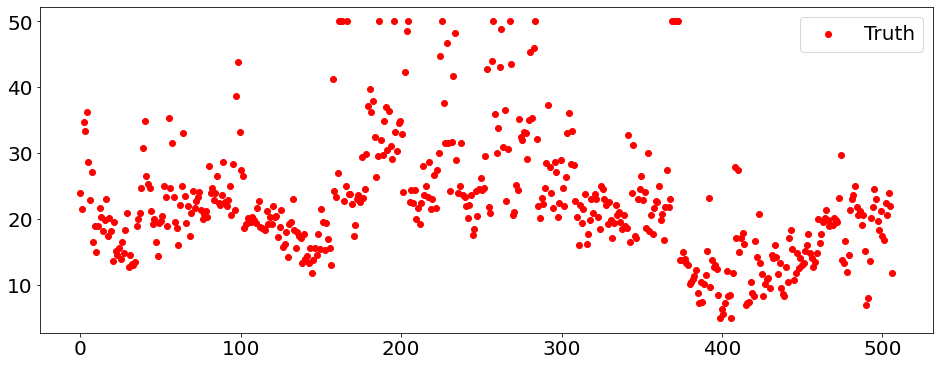

In [8]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots() 
ax.scatter(np.linspace(0,len(Y),len(Y)), Y, c="r", label = "Truth")
ax.legend()
plt.show()

# pyTorch model with no quantile regression

In [9]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()

        # second hidden layer
        self.hidden2 = Linear(10, 8)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()

        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X

In [10]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = MSELoss()
    #optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [11]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

In [12]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [13]:
# define the network
model = MLP(13)
# train the model
train_model(train_dl, model)
# evaluate the model
mse = evaluate_model(test_dl, model)
print('MSE: %.3f, RMSE: %.3f' % (mse, sqrt(mse)))
# make a single prediction (expect class=1)
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
yhat = predict(row, model)
print('Predicted: %.3f' % yhat)

MSE: 175.524, RMSE: 13.249
Predicted: 11.595


# Quantile regression implementation in pyTorch


- In the quantile loss class I’m squaring the outputs of these lower and upper quantile predictions to make the operation differntiable. 
- We could just take the absolute value here but the function has a sharp corner hence it is nondifferentiable and that will not help the gradient descent process.
- In one of mine notebook there is another suggested way to solve the **non-differentiablility** of the quantile loss function. In fact the talk about smooth and hard quantile loss function.
- The model is copied **two extra** times in order to get the offset from the prediction to the quantile.



In [14]:
class QuantileRegressor(nn.Module):
    def __init__(self, model):
        super().__init__()        
        self.model = model
        self.lower = copy.deepcopy(model)
        self.upper = copy.deepcopy(model)

    def forward(self, x):
        preds = self.model(x)
        lower = preds - self.lower(x) ** 2
        upper = preds + self.upper(x) ** 2
        return torch.cat([lower, preds, upper], dim = 1)


- The loss function then computes the mean of the three quantile losses: the two quantiles and the median. 
- I’ve used ReLU functions here to implement the control statement in the definition of the check function. 
- If we would like a smoother version we could replace the ReLU’s by its smoother variants such as the GELUs. 
- Note that, in the special case of the median, the quantile loss simply reduces to the absolute error.



In [15]:
class QuantileLoss(nn.Module):
    def __init__(self, alpha: float):
        super().__init__()
        self.lower, self.upper = ((1 - alpha) / 2, (1 + alpha) / 2)

    def forward(self, preds, target):
        residuals = target.unsqueeze(1) - preds
        lower_loss = torch.mean(F.relu(residuals[:, 0]) * self.lower -
          F.relu(-residuals[:, 0]) * (self.lower - 1))
        median_loss = torch.mean(torch.abs(residuals[:, 1]))
        upper_loss = torch.mean(F.relu(residuals[:, 2]) * self.upper -
          F.relu(-residuals[:, 2]) * (self.upper - 1))
        return (lower_loss + median_loss + upper_loss) / 3


- criterion = MSELoss() -> criterion = **QuantileLoss()**
- In order to be able to visually check the result I have intentionally used a vare large learning rate
- An usual learning rate would be in the order of 0.01



In [16]:
# train the model
def train_model_QuantileLoss(train_dl, model, alpha):
    # define the optimization
    criterion = QuantileLoss(alpha)
    #optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()


- We have our model instantiated as **model = MLP(13)**
- We now feed this model to the **QuantileRegressor** class which will create three instance of the model: lower,centre, upper
- We then proceed to train the model on the tain set    



In [17]:
# Create three instances of the model
modelQL = QuantileRegressor(model)
# Train the model
PI = 0.95
train_model_QuantileLoss(train_dl, modelQL, PI)


- yhat has three values [[lower,centre,upper], ..]
- We jsut need the middle one to report the model peformance



In [18]:
# evaluate the model
def evaluate_model_QR(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)[:,1]
        #yhat = Tensor(yhat)
        #print(yhat.shape)
        
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = hstack(predictions), vstack(actuals)
    #print(actuals.shape)
    #print(predictions.shape)
    
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

In [19]:
# evaluate the model
mse = evaluate_model_QR(test_dl, modelQL)
print('MSE: %.3f, RMSE: %.3f' % (mse, sqrt(mse)))

MSE: 78.161, RMSE: 8.841


In [20]:
# make a class prediction for one row of data
def predictInterval(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    #print(yhat)
    
    # retrieve numpy array
    #tensor([[21.8629, 21.8658, 21.8712]], grad_fn=<CatBackward>)
    yhat = yhat.detach().numpy()[0]    
    print("Lower PI: ", yhat[0], "prediction: ", yhat[1], "upper PI: ", yhat[2])
    return yhat[0], yhat[1], yhat[2]

In [21]:
# make a single prediction (expect class=1)
# [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
ID = 250
row = X[ID]
targetRow = Y[ID]
print(targetRow)
PI_lower, centre, PI_upper = predictInterval(row, modelQL)

[24.4]
Lower PI:  21.538095 prediction:  21.5396 upper PI:  21.564438


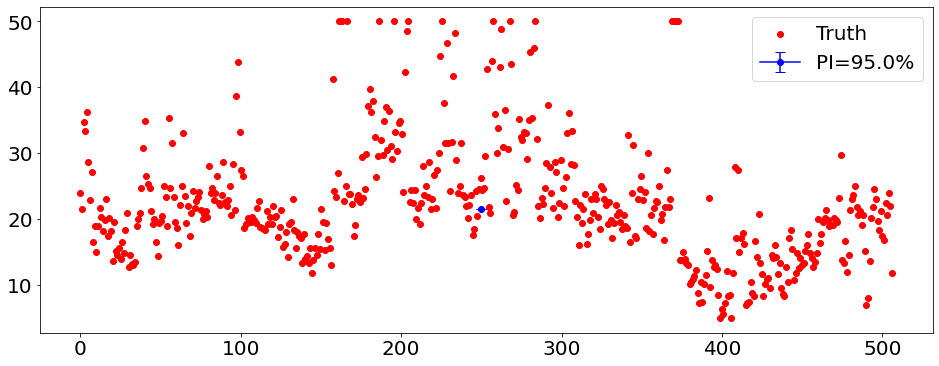

In [22]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots()
ax.scatter(np.linspace(0, len(Y), len(Y)), Y, c="r", label="Truth")

# The minus sign is added automatically by the error bar. That is why we use the abs()
deltaLOWER = abs(centre - PI_lower)
deltaUPPER = abs(centre - PI_upper)
pred = centre

ax.errorbar(ID, [pred], yerr=np.array([[deltaLOWER, deltaUPPER]]).T, fmt='bo-',
            solid_capstyle='projecting', capsize=5, label="PI=" + str(PI*100)+"%")

ax.legend()
plt.show()

# References


- https://saattrupdan.github.io/2020-03-09-quantile-regression/
- https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
- [Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv)

